In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

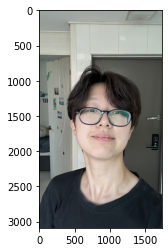

In [201]:
# 셀카 불러오기
image_path = '/aiffel/aiffel/셀.jpg'      # 이미지가 있는 경로
img_bgr = cv2.imread(image_path)    # OpenCV로 이미지를 불러옴
img = img_bgr.copy()                # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB 변경
plt.imshow(img_rgb)                 # 이미지를 출력하기 위해 출력할 이미지를 올려준다.(실제 출력은 하지 않음)
plt.show()

In [202]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [203]:
# rectangle 감지
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

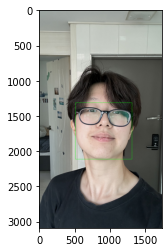

In [204]:
# 찾은 얼굴 영역 표시
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형

plt.imshow(img_rgb)
plt.show()

In [205]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [206]:
# 랜드마크의 위치를 저장할 list 생성 
list_landmarks = []   

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

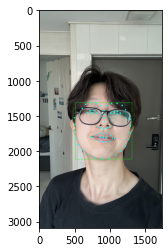

In [207]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_rgb 이미지 위 각각의 point에
            # 크기가 10이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

plt.imshow(img_rgb)
plt.show()
    # 이미지를 출력

In [208]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 코끝 33번
    x = landmark[33][0]
    y = landmark[33][1]
    w = int(dlib_rect.width() * 1.5) # 얼굴 영역 가로의 1.5배
    h = dlib_rect.height() // 2 # 얼굴 영역 세로의 1/2
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(x,y) : (914,1682)
(w,h) : (1200,400)


In [209]:
# 스티커 이미지 읽어오기
sticker_path = '/aiffel/aiffel/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정
print (img_sticker.shape) # 사이즈를 조정한 이미지의 차원 확인

(400, 1200, 3)


In [210]:
refined_x = x - w//2
refined_y = y - h//2
# x, y 좌표를 이미지 시작점 top-left 좌표로 조정
# 즉, refined_x, refined_y값에서 수염 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (314,1482)


In [211]:
# 이미지 범위 조정하는 함수
def img_resize(refined_x, refined_y, img_sticker):
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    return refined_x, refined_y, img_sticker

314 1482


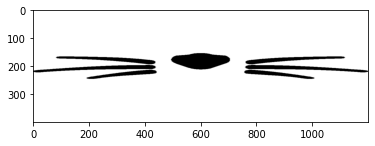

In [212]:
# 함수 적용
refined_x, refined_y, img_sticker = img_resize(refined_x, refined_y, img_sticker)
print(refined_x, refined_y)
plt.imshow(img_sticker)
plt.show()

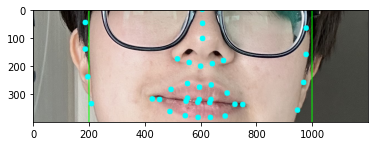

In [213]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 좌표 순서가 y,x임에 유의. (y,x,rgb channel)
# img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
sticker_area = img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
plt.imshow(sticker_area)
plt.show()
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용
# 왕관 이미지에서 255가 나오는 부분은 이미지가 없다 => 제외하고 적용
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는
# sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

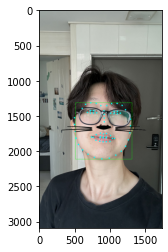

In [214]:
# 적용한 이미지 출력
plt.imshow(img_rgb)
plt.show()

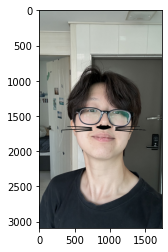

In [215]:
# 클린한 이미지에 출력
sticker_area_origin = img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area_origin,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [224]:
# 위 과정을 전부 함수로 만들기
def img_sticker_attach(img_path, sticker_path):
    img_bgr = cv2.imread(img_path)                   # 원본 bgr 이미지
    img_prt = img_bgr.copy()                           # 출력용 이미지
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # rgb 변경 이미지
    
    img_sticker = cv2.imread(sticker_path)             # 스티커 이미지
    
    # landmark perdictor model
    model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    # 랜드마크의 위치를 저장할 list 생성 
    list_landmarks = []   

    # 얼굴 영역 박스 마다 face landmark를 찾아냄
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
            # 모든 landmark의 위치정보를 points 변수에 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_landmarks.append(list_points)
            # list_landmarks에 랜드마크 리스트를 저장
    
    # landmark 위치 확인
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_rgb, point, 10, (0, 255, 255), -1)
                # 크기가 10이고 (0, 255, 255)색으로 내부가 채워진(-1) 원
    plt.imshow(img_rgb)
    plt.show()
    
    # 스티커 위치 지정
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # 코끝 33번
        x = landmark[33][0]
        y = landmark[33][1]
        w = int(dlib_rect.width() * 1.5) # 얼굴 영역 가로의 1.5배
        h = dlib_rect.height() // 2 # 얼굴 영역 세로의 1/2
    
    img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 크기 조정
    # x, y 좌표를 이미지 시작점 top-left 좌표로 조정
    refined_x = x - w//2
    refined_y = y - h//2
    # 잘리는 부분 크기 조정
    refined_x, refined_y, img_sticker = img_resize(refined_x, refined_y, img_sticker)
    # 원본에서 스티커 붙을 부분 자름
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    # 스티커에서 흰색은 빼고 나머지 부분만 출력
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    # 컬러 조정 후 출력
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

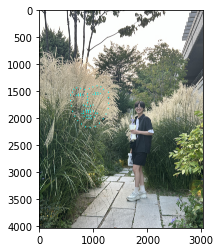

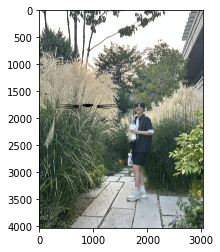

In [225]:
# 실험 1. 멀리서 찍은 사진
image_far_path = '/aiffel/aiffel/멀리.jpg'
img_sticker_attach(image_far_path,sticker_path)

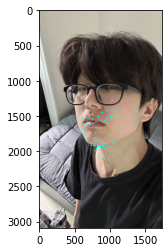

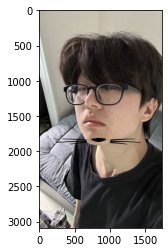

In [226]:
# 실험 2. 얼굴 각도에 따른 변화
image_angle_path = '/aiffel/aiffel/각도.jpg'
img_sticker_attach(image_angle_path,sticker_path)

In [ ]:
# 회고
"""
이미지 객체를 직접 수정하니 실패했을 때 코드를 처음부터 다시 돌려 객체를 초기화해야 하는 문제가 있다.
또한 멀리서 찍은 사진이나 얼굴 각도가 다르게 나온 사진은 얼굴을 잘 인식하지 못한다.
이는 모델의 문제로 학습하지 않고 하드코딩된 모델이기 때문에 다양한 상황에 적응하지 못하는 것으로 보인다.
"""